# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

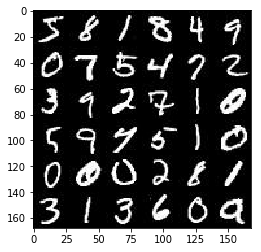

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

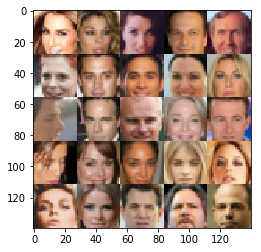

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # Generator and Discriminator inputs
    real = tf.placeholder(dtype=tf.float32, shape=(None, image_height, image_width, image_channels), name="real_input")
    z = tf.placeholder(dtype=tf.float32, shape=(None,z_dim), name="z_input")
    
    # Learning rate
    lr = tf.placeholder(dtype=tf.float32, name="learning_rate")
    
    return real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [61]:
from tensorflow.contrib.layers import dropout
""" Discriminator Hyperparameters:
      alpha: leaky_relu's alpha
      keep_prob: dropout
"""
alpha = 0.2
keep_prob = .8


# Activation functions:

def leaky_relu(x,alpha=0.2):
    return tf.maximum(x,x*alpha)

def swish(x):
    return tf.nn.sigmoid(x) * x

# Convolution Layer
def conv(layer, filters, kernel_size=5, strides=2, padding="same", activation=None):
    # initializer
    xavier_initializer = tf.contrib.layers.xavier_initializer()

    # dropout batch_norm, conv, leaky
    layer = dropout(layer, keep_prob=keep_prob, is_training=True)
    layer = tf.layers.batch_normalization(layer, training = True)
    layer = tf.layers.conv2d(layer, filters, kernel_size, strides=strides, padding=padding, activation=None, kernel_initializer=xavier_initializer)
    layer = leaky_relu(layer, alpha)
    
    #print(layer.get_shape())
    

    return layer


# # # # # # # # # # # #

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        """
        Architecture used:
            struct:
                FC -> leaky -> ( FC -> batch_norm -> leaky ) x 3
                Flatten -> logits -> out (sigmoid)
                    
            shape :
                28x28x3 -> 14x14x32 -> 7x7x64 -> 4x4x128 -> 2x2x256
        """
        
        # Layers
        xavier_initializer = tf.contrib.layers.xavier_initializer()
        layer = tf.layers.conv2d(images, 32, 3, strides=2, padding="same", activation=tf.tanh, kernel_initializer=xavier_initializer)
        
        layer = conv(layer, 64, kernel_size=3)
        layer = conv(layer, 128, kernel_size=4)
        layer = conv(layer, 256, kernel_size=4)
        
        layer = conv(layer, 512, kernel_size=5)
        
        # logits, output
        flat = tf.reshape(layer, (-1,512)) #changed from 1024 -> 512
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
    

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [62]:

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    
    # Controls
    alpha = 0.2
    keep_prob = 0.9

    def conv_T(layer, filters, strides=2, padding='same', kernel_size=5, use_bias=False):

        xavier_initializer = tf.contrib.layers.xavier_initializer()
        layer = dropout(layer, keep_prob=keep_prob, is_training=is_train)
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.conv2d_transpose(layer, filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias, activation=None, kernel_initializer=xavier_initializer)

        layer = leaky_relu(layer, alpha)

        
        return layer

    with tf.variable_scope('generator', reuse=reuse):  
        
        # Structure
        # dense -> reshape
        layer = tf.layers.dense(z, 2**13, activation=None) # activation used to be tanh
        layer = tf.reshape(layer, (-1,4,4,512)) # (4x4x512)
        
        # Convolution Layers
        layer = conv_T(layer, 256, strides=1, padding='valid', kernel_size=4) # (7x7x256)
        layer = conv_T(layer, 128, kernel_size=4)   # (14x14x128)
        layer = conv_T(layer, 64, kernel_size=3)    # (28x28x64)
        
        # single strides convolutions
        layer = conv_T(layer, 32, strides=1, kernel_size=3)    # (28x28x32)
        layer = conv_T(layer, 16, strides=1, kernel_size=2)    # (28x28x16)
        
        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, 2, strides=1, padding='same', use_bias=False, activation=None)      
        output = tf.tanh(logits)

       
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # img_dim = input_real.get_shape()[1:]
    # blur = tf.random_normal(img_dim) * added_noise
    # input_real = tf.add(input_real,blur)
    
    # Models & Logits
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Label Smoothing
    smooth = .1
    labels_smoothed = tf.ones_like(d_model_real) * (1-smooth)
    
    # Discriminator losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_smoothed))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator losses
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [64]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get Weights and Bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    # Optimize                                  
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt

In [67]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # get inputs
    n_samples, width, height, depth = data_shape
    real_input, z_input, lr = model_inputs(width, height, depth, z_dim)
    
    # normalize the real input [-.5,.5]->[-1,1] to match the generator output (tanh~)
    real_input_normalized = 2 * real_input
    
    # optimize
    d_loss, g_loss = model_loss(real_input_normalized, z_input, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        samples, losses = [], []
        steps = 0
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1,1,(batch_size, z_dim))
                
                discriminator = sess.run(d_opt, feed_dict={real_input:batch_images, z_input: batch_z, lr: learning_rate})
                generator = sess.run(g_opt, feed_dict={real_input:batch_images, z_input: batch_z, lr: learning_rate})
                              
              
                if steps % 100 == 0 or steps == 1:
                    
                    # Print losses
                    dloss = d_loss.eval({real_input: batch_images, z_input: batch_z, lr: learning_rate})
                    gloss = g_loss.eval({z_input: batch_z})
                    losses.append((dloss,gloss))
                    
                    print("step: {}, epoch: {}/{}".format(steps,epoch_i+1,epoch_count),
                          "Loss => Discriminator: {:.6f}, Generator: {:.6f}".format(dloss,gloss))
                
                    # Print generator output
                    if (steps % 200 == 0) or (steps == 1):
                        show_generator_output(sess, 16, z_input,depth,data_image_mode)
        
        # Final Report:
        print("\n#############\nFinal Results:\n#############")
        show_generator_output(sess, 50, z_input, depth, data_image_mode)
        
        print("\n#############\nLosses:\n#############")
        fig, ax = plt.subplots()
        losses = np.array(losses).T
        plt.plot(losses[0], label='Discriminator')
        plt.plot(losses[1], label='Generator')
        plt.title("Training Losses")
        plt.legend() 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

step: 1, epoch: 1/2 Loss => Discriminator: 1.077334, Generator: 0.631418


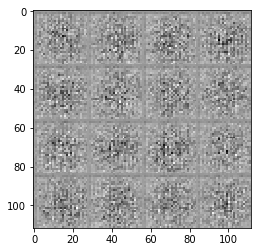

step: 100, epoch: 1/2 Loss => Discriminator: 1.176164, Generator: 1.153157
step: 200, epoch: 1/2 Loss => Discriminator: 1.350709, Generator: 1.174484


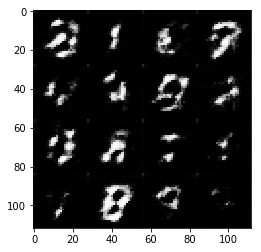

step: 300, epoch: 1/2 Loss => Discriminator: 1.255266, Generator: 0.825235
step: 400, epoch: 1/2 Loss => Discriminator: 1.121499, Generator: 0.830429


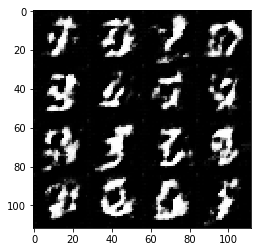

step: 500, epoch: 1/2 Loss => Discriminator: 1.238196, Generator: 1.060382
step: 600, epoch: 1/2 Loss => Discriminator: 1.199131, Generator: 1.016873


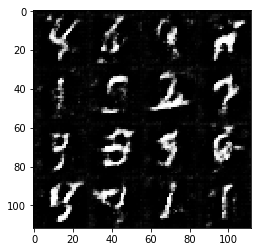

step: 700, epoch: 1/2 Loss => Discriminator: 1.300534, Generator: 0.696418
step: 800, epoch: 1/2 Loss => Discriminator: 1.066649, Generator: 0.972238


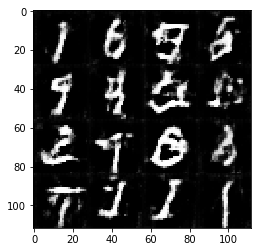

step: 900, epoch: 1/2 Loss => Discriminator: 0.909526, Generator: 1.021258
step: 1000, epoch: 1/2 Loss => Discriminator: 1.327498, Generator: 0.788197


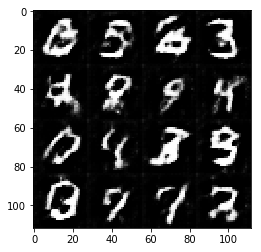

step: 1100, epoch: 1/2 Loss => Discriminator: 1.336813, Generator: 0.985286
step: 1200, epoch: 1/2 Loss => Discriminator: 1.160478, Generator: 0.960856


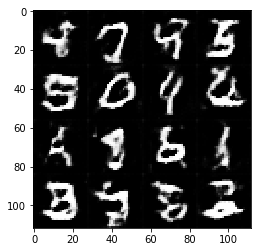

step: 1300, epoch: 1/2 Loss => Discriminator: 1.314982, Generator: 1.131611
step: 1400, epoch: 1/2 Loss => Discriminator: 1.084805, Generator: 0.863581


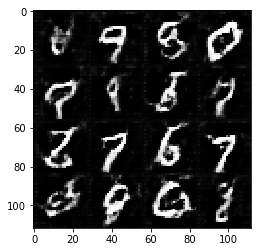

step: 1500, epoch: 1/2 Loss => Discriminator: 1.076053, Generator: 1.128584
step: 1600, epoch: 1/2 Loss => Discriminator: 1.533721, Generator: 0.687097


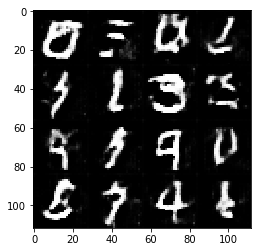

step: 1700, epoch: 1/2 Loss => Discriminator: 1.329576, Generator: 0.645644
step: 1800, epoch: 1/2 Loss => Discriminator: 1.116625, Generator: 1.008973


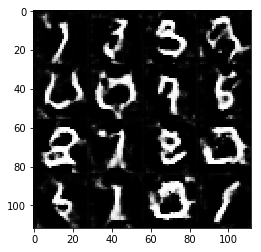

step: 1900, epoch: 1/2 Loss => Discriminator: 1.110028, Generator: 1.178301
step: 2000, epoch: 1/2 Loss => Discriminator: 1.024646, Generator: 0.878342


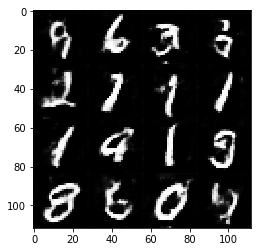

step: 2100, epoch: 1/2 Loss => Discriminator: 1.320524, Generator: 0.751935
step: 2200, epoch: 1/2 Loss => Discriminator: 1.109127, Generator: 0.981275


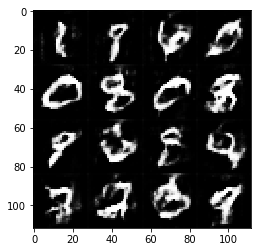

step: 2300, epoch: 1/2 Loss => Discriminator: 1.369487, Generator: 0.893348
step: 2400, epoch: 1/2 Loss => Discriminator: 1.041438, Generator: 1.297920


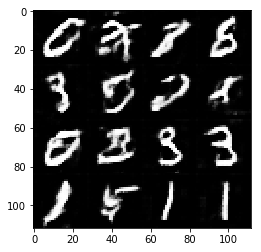

step: 2500, epoch: 1/2 Loss => Discriminator: 1.159950, Generator: 0.998476
step: 2600, epoch: 1/2 Loss => Discriminator: 1.204169, Generator: 0.773670


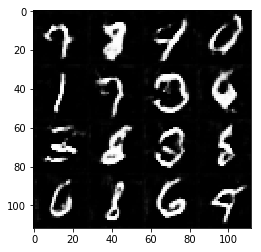

step: 2700, epoch: 1/2 Loss => Discriminator: 1.066992, Generator: 0.869027
step: 2800, epoch: 1/2 Loss => Discriminator: 1.009210, Generator: 1.048746


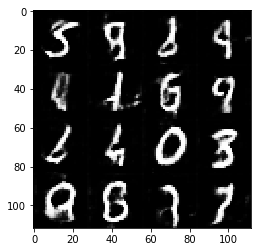

step: 2900, epoch: 1/2 Loss => Discriminator: 1.202137, Generator: 1.081111
step: 3000, epoch: 1/2 Loss => Discriminator: 1.103839, Generator: 0.843965


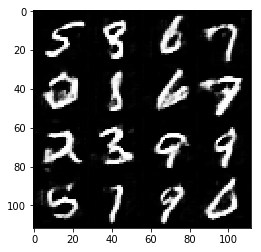

step: 3100, epoch: 1/2 Loss => Discriminator: 1.311717, Generator: 0.867820
step: 3200, epoch: 1/2 Loss => Discriminator: 1.055075, Generator: 1.671665


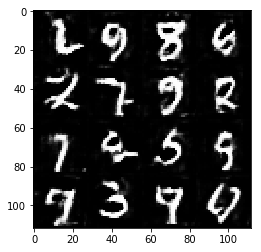

step: 3300, epoch: 1/2 Loss => Discriminator: 1.320143, Generator: 0.742882
step: 3400, epoch: 1/2 Loss => Discriminator: 1.169399, Generator: 1.238529


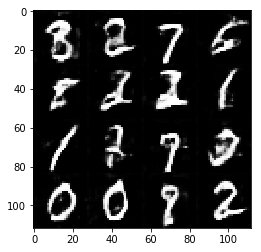

step: 3500, epoch: 1/2 Loss => Discriminator: 1.249945, Generator: 1.058758
step: 3600, epoch: 1/2 Loss => Discriminator: 0.886277, Generator: 0.828860


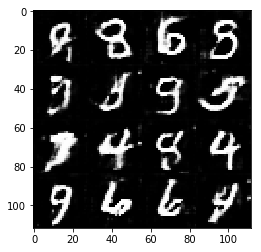

step: 3700, epoch: 1/2 Loss => Discriminator: 1.291489, Generator: 0.873244
step: 3800, epoch: 2/2 Loss => Discriminator: 1.459095, Generator: 0.635227


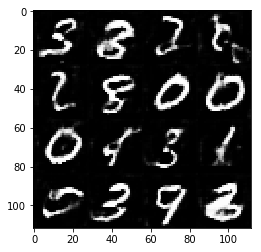

step: 3900, epoch: 2/2 Loss => Discriminator: 1.029437, Generator: 1.142318
step: 4000, epoch: 2/2 Loss => Discriminator: 1.106958, Generator: 1.171629


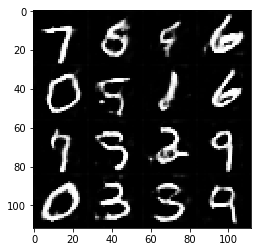

step: 4100, epoch: 2/2 Loss => Discriminator: 1.111030, Generator: 1.007357
step: 4200, epoch: 2/2 Loss => Discriminator: 1.006934, Generator: 1.232451


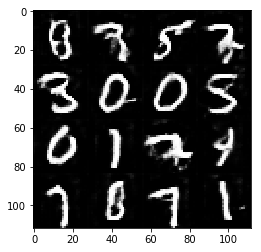

step: 4300, epoch: 2/2 Loss => Discriminator: 1.329282, Generator: 0.629521
step: 4400, epoch: 2/2 Loss => Discriminator: 1.500737, Generator: 0.682071


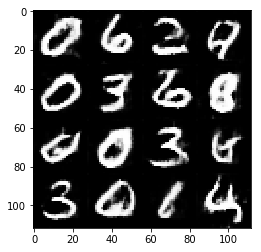

step: 4500, epoch: 2/2 Loss => Discriminator: 0.890631, Generator: 0.906332
step: 4600, epoch: 2/2 Loss => Discriminator: 1.325012, Generator: 0.877364


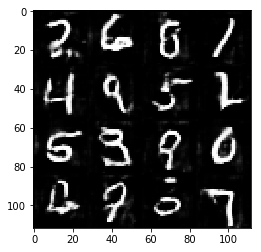

step: 4700, epoch: 2/2 Loss => Discriminator: 1.002938, Generator: 1.118976
step: 4800, epoch: 2/2 Loss => Discriminator: 1.208564, Generator: 1.250441


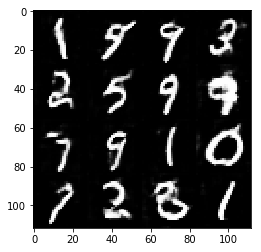

step: 4900, epoch: 2/2 Loss => Discriminator: 1.162793, Generator: 0.664011
step: 5000, epoch: 2/2 Loss => Discriminator: 1.268237, Generator: 0.644997


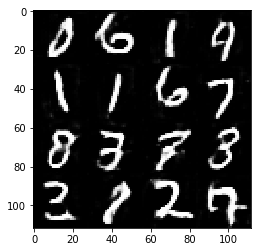

step: 5100, epoch: 2/2 Loss => Discriminator: 1.291185, Generator: 0.915022
step: 5200, epoch: 2/2 Loss => Discriminator: 1.372516, Generator: 0.724275


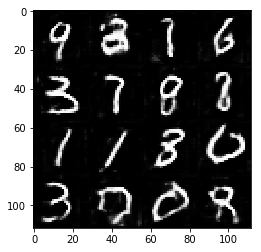

step: 5300, epoch: 2/2 Loss => Discriminator: 1.271907, Generator: 0.777963
step: 5400, epoch: 2/2 Loss => Discriminator: 1.183431, Generator: 0.704100


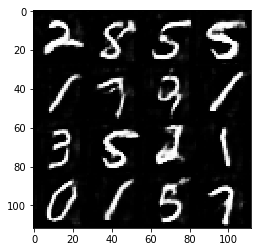

step: 5500, epoch: 2/2 Loss => Discriminator: 1.146398, Generator: 1.185154
step: 5600, epoch: 2/2 Loss => Discriminator: 1.212795, Generator: 0.841045


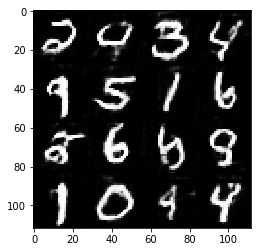

step: 5700, epoch: 2/2 Loss => Discriminator: 1.019389, Generator: 0.937290
step: 5800, epoch: 2/2 Loss => Discriminator: 1.319046, Generator: 0.949230


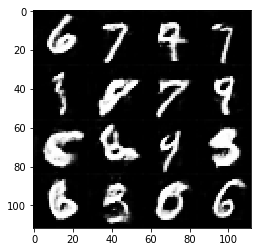

step: 5900, epoch: 2/2 Loss => Discriminator: 1.000006, Generator: 1.207063
step: 6000, epoch: 2/2 Loss => Discriminator: 1.522659, Generator: 0.915203


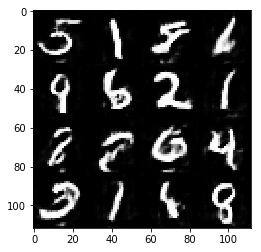

step: 6100, epoch: 2/2 Loss => Discriminator: 1.133231, Generator: 1.133841
step: 6200, epoch: 2/2 Loss => Discriminator: 1.069991, Generator: 0.842970


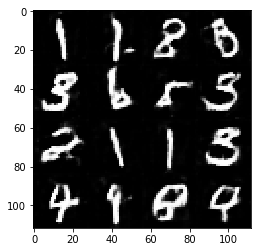

step: 6300, epoch: 2/2 Loss => Discriminator: 1.036075, Generator: 0.881887
step: 6400, epoch: 2/2 Loss => Discriminator: 1.169798, Generator: 0.781493


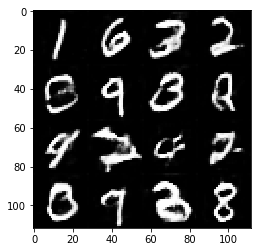

step: 6500, epoch: 2/2 Loss => Discriminator: 1.144835, Generator: 1.125852
step: 6600, epoch: 2/2 Loss => Discriminator: 1.734235, Generator: 0.760765


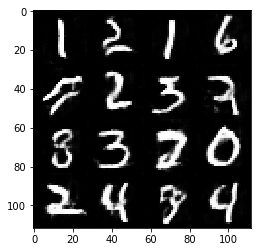

step: 6700, epoch: 2/2 Loss => Discriminator: 1.170482, Generator: 1.021655
step: 6800, epoch: 2/2 Loss => Discriminator: 1.466335, Generator: 0.672513


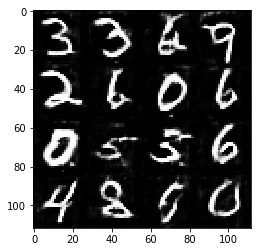

step: 6900, epoch: 2/2 Loss => Discriminator: 1.539807, Generator: 0.829433
step: 7000, epoch: 2/2 Loss => Discriminator: 1.117375, Generator: 1.303346


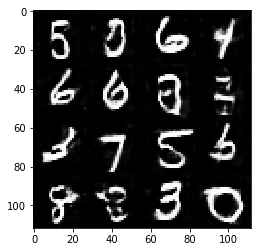

step: 7100, epoch: 2/2 Loss => Discriminator: 0.980098, Generator: 0.880548
step: 7200, epoch: 2/2 Loss => Discriminator: 1.172860, Generator: 0.919234


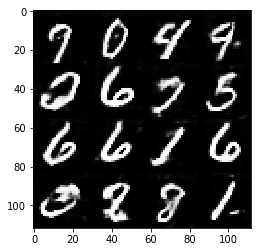

step: 7300, epoch: 2/2 Loss => Discriminator: 1.241639, Generator: 0.818675
step: 7400, epoch: 2/2 Loss => Discriminator: 1.034007, Generator: 1.101376


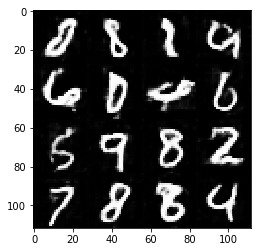

step: 7500, epoch: 2/2 Loss => Discriminator: 0.935690, Generator: 0.900425

#############
Final Results:
#############


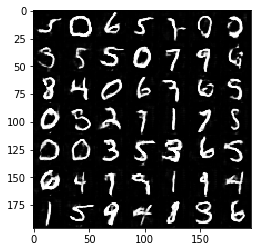


#############
Losses:
#############


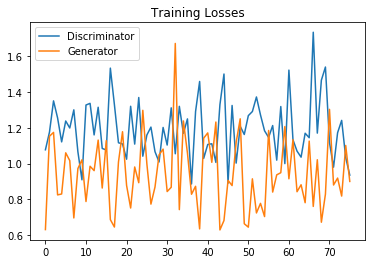

In [69]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

step: 1, epoch: 1/1 Loss => Discriminator: 1.355054, Generator: 0.719533


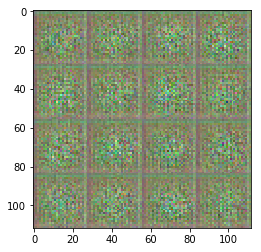

step: 100, epoch: 1/1 Loss => Discriminator: 1.299159, Generator: 0.919717
step: 200, epoch: 1/1 Loss => Discriminator: 0.593728, Generator: 2.995932
step: 300, epoch: 1/1 Loss => Discriminator: 0.449585, Generator: 5.459268
step: 400, epoch: 1/1 Loss => Discriminator: 0.771735, Generator: 1.826406
step: 500, epoch: 1/1 Loss => Discriminator: 0.881043, Generator: 2.633976


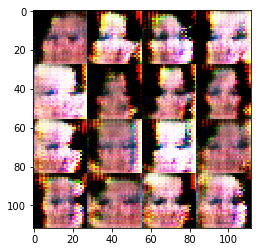

step: 600, epoch: 1/1 Loss => Discriminator: 0.643767, Generator: 2.648311
step: 700, epoch: 1/1 Loss => Discriminator: 1.083931, Generator: 0.918557
step: 800, epoch: 1/1 Loss => Discriminator: 0.927463, Generator: 1.287458
step: 900, epoch: 1/1 Loss => Discriminator: 1.533043, Generator: 1.237062
step: 1000, epoch: 1/1 Loss => Discriminator: 1.089198, Generator: 0.771422


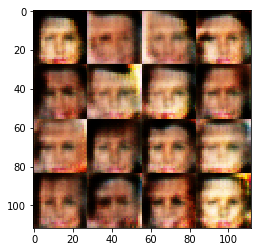

step: 1100, epoch: 1/1 Loss => Discriminator: 1.141736, Generator: 0.743122
step: 1200, epoch: 1/1 Loss => Discriminator: 1.383254, Generator: 0.780839
step: 1300, epoch: 1/1 Loss => Discriminator: 1.140826, Generator: 1.164580
step: 1400, epoch: 1/1 Loss => Discriminator: 1.143049, Generator: 1.041361
step: 1500, epoch: 1/1 Loss => Discriminator: 1.184776, Generator: 1.049822


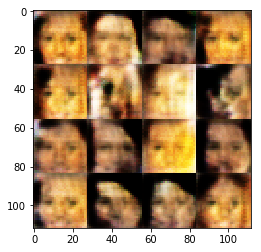

step: 1600, epoch: 1/1 Loss => Discriminator: 1.302267, Generator: 0.967885
step: 1700, epoch: 1/1 Loss => Discriminator: 1.141155, Generator: 0.779985
step: 1800, epoch: 1/1 Loss => Discriminator: 1.316440, Generator: 0.919428
step: 1900, epoch: 1/1 Loss => Discriminator: 1.400026, Generator: 0.891917
step: 2000, epoch: 1/1 Loss => Discriminator: 1.216974, Generator: 0.911830


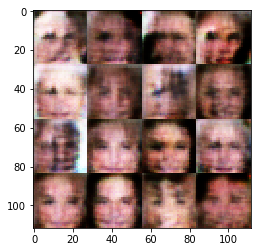

step: 2100, epoch: 1/1 Loss => Discriminator: 1.247508, Generator: 0.907684
step: 2200, epoch: 1/1 Loss => Discriminator: 1.299282, Generator: 0.907270
step: 2300, epoch: 1/1 Loss => Discriminator: 1.273481, Generator: 0.777849
step: 2400, epoch: 1/1 Loss => Discriminator: 1.384364, Generator: 0.792529
step: 2500, epoch: 1/1 Loss => Discriminator: 1.175329, Generator: 0.927857


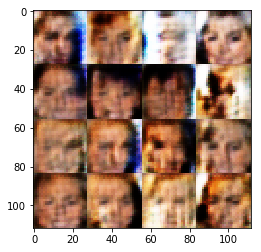

step: 2600, epoch: 1/1 Loss => Discriminator: 1.389992, Generator: 0.816550
step: 2700, epoch: 1/1 Loss => Discriminator: 1.321816, Generator: 0.785625
step: 2800, epoch: 1/1 Loss => Discriminator: 1.319175, Generator: 0.908119
step: 2900, epoch: 1/1 Loss => Discriminator: 1.240292, Generator: 0.807892
step: 3000, epoch: 1/1 Loss => Discriminator: 1.347248, Generator: 0.849721


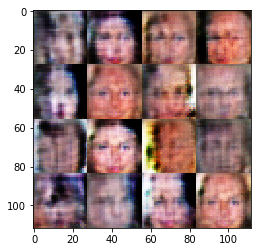

step: 3100, epoch: 1/1 Loss => Discriminator: 1.221765, Generator: 0.980748
step: 3200, epoch: 1/1 Loss => Discriminator: 1.209936, Generator: 0.903289
step: 3300, epoch: 1/1 Loss => Discriminator: 1.306109, Generator: 0.854388
step: 3400, epoch: 1/1 Loss => Discriminator: 1.375235, Generator: 0.825666
step: 3500, epoch: 1/1 Loss => Discriminator: 1.282892, Generator: 0.785527


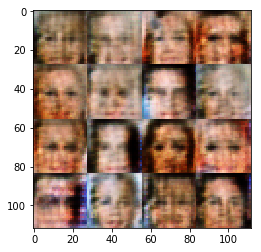

step: 3600, epoch: 1/1 Loss => Discriminator: 1.199724, Generator: 0.943179
step: 3700, epoch: 1/1 Loss => Discriminator: 1.265926, Generator: 0.880983
step: 3800, epoch: 1/1 Loss => Discriminator: 1.198107, Generator: 0.891485
step: 3900, epoch: 1/1 Loss => Discriminator: 1.274723, Generator: 0.789375
step: 4000, epoch: 1/1 Loss => Discriminator: 1.250859, Generator: 0.871681


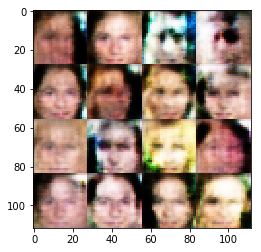

step: 4100, epoch: 1/1 Loss => Discriminator: 1.232436, Generator: 0.872917
step: 4200, epoch: 1/1 Loss => Discriminator: 1.382794, Generator: 0.872414
step: 4300, epoch: 1/1 Loss => Discriminator: 1.307262, Generator: 0.866249
step: 4400, epoch: 1/1 Loss => Discriminator: 1.355382, Generator: 0.849655
step: 4500, epoch: 1/1 Loss => Discriminator: 1.377732, Generator: 0.774629


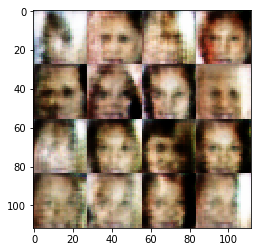

step: 4600, epoch: 1/1 Loss => Discriminator: 1.224281, Generator: 0.806124
step: 4700, epoch: 1/1 Loss => Discriminator: 1.258881, Generator: 0.670215
step: 4800, epoch: 1/1 Loss => Discriminator: 1.270949, Generator: 0.813322
step: 4900, epoch: 1/1 Loss => Discriminator: 1.260314, Generator: 0.886715
step: 5000, epoch: 1/1 Loss => Discriminator: 1.331808, Generator: 0.833666


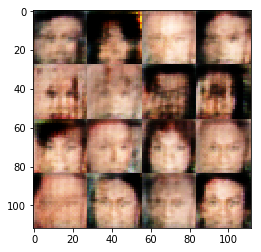

step: 5100, epoch: 1/1 Loss => Discriminator: 1.486685, Generator: 0.703568
step: 5200, epoch: 1/1 Loss => Discriminator: 1.379033, Generator: 0.726383
step: 5300, epoch: 1/1 Loss => Discriminator: 1.280856, Generator: 0.769647
step: 5400, epoch: 1/1 Loss => Discriminator: 1.364574, Generator: 0.807778
step: 5500, epoch: 1/1 Loss => Discriminator: 1.148213, Generator: 0.839758


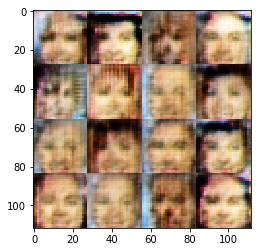

step: 5600, epoch: 1/1 Loss => Discriminator: 1.248062, Generator: 0.871831
step: 5700, epoch: 1/1 Loss => Discriminator: 1.351475, Generator: 0.870640
step: 5800, epoch: 1/1 Loss => Discriminator: 1.328879, Generator: 0.860837
step: 5900, epoch: 1/1 Loss => Discriminator: 1.296382, Generator: 0.846609
step: 6000, epoch: 1/1 Loss => Discriminator: 1.307927, Generator: 0.837674


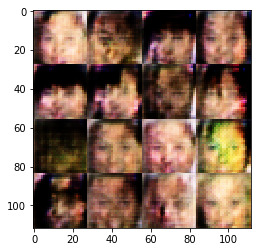

step: 6100, epoch: 1/1 Loss => Discriminator: 1.382467, Generator: 0.850340
step: 6200, epoch: 1/1 Loss => Discriminator: 1.281910, Generator: 0.955879
step: 6300, epoch: 1/1 Loss => Discriminator: 1.366942, Generator: 0.968845
step: 6400, epoch: 1/1 Loss => Discriminator: 1.347731, Generator: 0.923481
step: 6500, epoch: 1/1 Loss => Discriminator: 1.310524, Generator: 0.893776


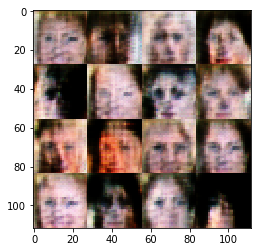

step: 6600, epoch: 1/1 Loss => Discriminator: 1.432808, Generator: 0.958137
step: 6700, epoch: 1/1 Loss => Discriminator: 1.365012, Generator: 0.713333
step: 6800, epoch: 1/1 Loss => Discriminator: 1.213837, Generator: 0.906835
step: 6900, epoch: 1/1 Loss => Discriminator: 1.261567, Generator: 0.749334
step: 7000, epoch: 1/1 Loss => Discriminator: 1.332975, Generator: 0.913411


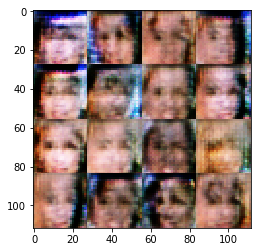

step: 7100, epoch: 1/1 Loss => Discriminator: 1.205133, Generator: 0.997628
step: 7200, epoch: 1/1 Loss => Discriminator: 1.256181, Generator: 0.950821
step: 7300, epoch: 1/1 Loss => Discriminator: 1.084218, Generator: 0.848443
step: 7400, epoch: 1/1 Loss => Discriminator: 1.358346, Generator: 0.982964
step: 7500, epoch: 1/1 Loss => Discriminator: 1.296163, Generator: 0.817751


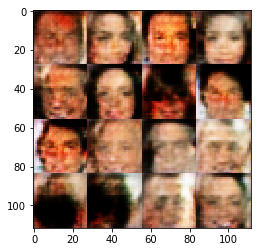

step: 7600, epoch: 1/1 Loss => Discriminator: 1.053041, Generator: 1.027659
step: 7700, epoch: 1/1 Loss => Discriminator: 1.190484, Generator: 0.915589
step: 7800, epoch: 1/1 Loss => Discriminator: 1.154786, Generator: 0.829909
step: 7900, epoch: 1/1 Loss => Discriminator: 1.097157, Generator: 0.863141
step: 8000, epoch: 1/1 Loss => Discriminator: 1.192474, Generator: 0.845217


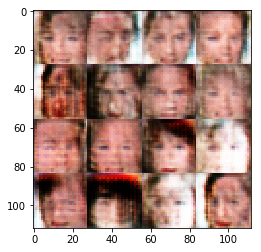

step: 8100, epoch: 1/1 Loss => Discriminator: 1.275261, Generator: 1.066905
step: 8200, epoch: 1/1 Loss => Discriminator: 1.274109, Generator: 0.940008
step: 8300, epoch: 1/1 Loss => Discriminator: 1.146264, Generator: 0.959205
step: 8400, epoch: 1/1 Loss => Discriminator: 1.161596, Generator: 0.933948
step: 8500, epoch: 1/1 Loss => Discriminator: 1.174403, Generator: 1.075111


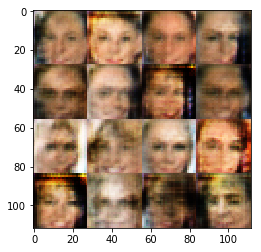

step: 8600, epoch: 1/1 Loss => Discriminator: 1.367880, Generator: 0.908631
step: 8700, epoch: 1/1 Loss => Discriminator: 1.470374, Generator: 0.751331
step: 8800, epoch: 1/1 Loss => Discriminator: 1.305235, Generator: 0.909575
step: 8900, epoch: 1/1 Loss => Discriminator: 1.385730, Generator: 1.054464
step: 9000, epoch: 1/1 Loss => Discriminator: 1.231102, Generator: 0.922238


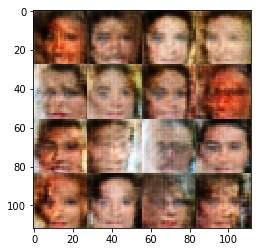

step: 9100, epoch: 1/1 Loss => Discriminator: 1.225107, Generator: 0.996295
step: 9200, epoch: 1/1 Loss => Discriminator: 1.252798, Generator: 0.979355
step: 9300, epoch: 1/1 Loss => Discriminator: 1.219762, Generator: 0.895968
step: 9400, epoch: 1/1 Loss => Discriminator: 1.252706, Generator: 0.832116
step: 9500, epoch: 1/1 Loss => Discriminator: 1.225081, Generator: 0.870351


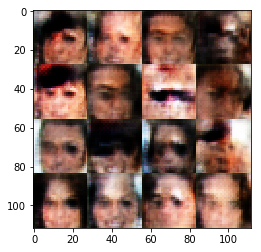

step: 9600, epoch: 1/1 Loss => Discriminator: 1.277440, Generator: 0.751945
step: 9700, epoch: 1/1 Loss => Discriminator: 1.337053, Generator: 0.895588
step: 9800, epoch: 1/1 Loss => Discriminator: 1.313020, Generator: 0.850284
step: 9900, epoch: 1/1 Loss => Discriminator: 1.258489, Generator: 1.005333
step: 10000, epoch: 1/1 Loss => Discriminator: 1.397111, Generator: 0.678692


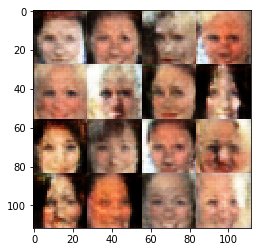

step: 10100, epoch: 1/1 Loss => Discriminator: 1.287629, Generator: 0.771650
step: 10200, epoch: 1/1 Loss => Discriminator: 1.426016, Generator: 0.713007
step: 10300, epoch: 1/1 Loss => Discriminator: 1.241740, Generator: 0.890784
step: 10400, epoch: 1/1 Loss => Discriminator: 1.333215, Generator: 0.763574
step: 10500, epoch: 1/1 Loss => Discriminator: 1.248022, Generator: 0.954738


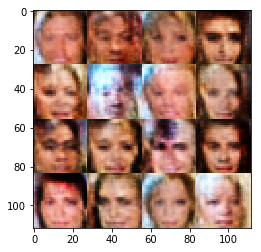

step: 10600, epoch: 1/1 Loss => Discriminator: 1.354232, Generator: 0.862014
step: 10700, epoch: 1/1 Loss => Discriminator: 1.308325, Generator: 0.880259
step: 10800, epoch: 1/1 Loss => Discriminator: 1.213583, Generator: 0.926724
step: 10900, epoch: 1/1 Loss => Discriminator: 1.209268, Generator: 0.938508
step: 11000, epoch: 1/1 Loss => Discriminator: 1.256435, Generator: 0.869428


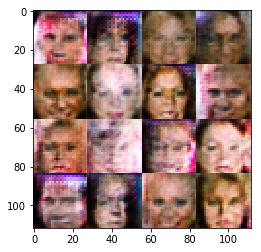

step: 11100, epoch: 1/1 Loss => Discriminator: 1.303524, Generator: 0.898156
step: 11200, epoch: 1/1 Loss => Discriminator: 1.254927, Generator: 0.988633
step: 11300, epoch: 1/1 Loss => Discriminator: 1.329967, Generator: 0.737901
step: 11400, epoch: 1/1 Loss => Discriminator: 1.222027, Generator: 0.897158
step: 11500, epoch: 1/1 Loss => Discriminator: 1.290074, Generator: 0.919994


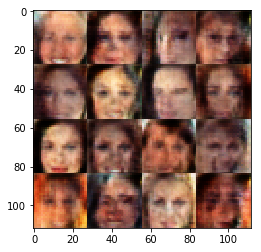

step: 11600, epoch: 1/1 Loss => Discriminator: 1.200725, Generator: 0.785136
step: 11700, epoch: 1/1 Loss => Discriminator: 1.344761, Generator: 0.950780
step: 11800, epoch: 1/1 Loss => Discriminator: 1.308315, Generator: 0.829186
step: 11900, epoch: 1/1 Loss => Discriminator: 1.189243, Generator: 0.850911
step: 12000, epoch: 1/1 Loss => Discriminator: 1.319036, Generator: 0.828489


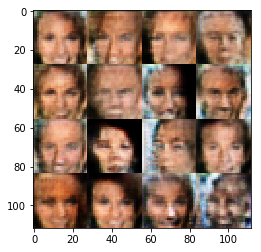

step: 12100, epoch: 1/1 Loss => Discriminator: 1.223326, Generator: 0.981110
step: 12200, epoch: 1/1 Loss => Discriminator: 1.177406, Generator: 1.042272
step: 12300, epoch: 1/1 Loss => Discriminator: 1.168102, Generator: 0.763793
step: 12400, epoch: 1/1 Loss => Discriminator: 1.248876, Generator: 0.849396
step: 12500, epoch: 1/1 Loss => Discriminator: 1.323621, Generator: 0.882162


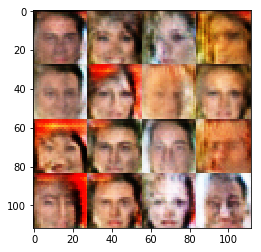

step: 12600, epoch: 1/1 Loss => Discriminator: 1.361284, Generator: 1.074951

#############
Final Results:
#############


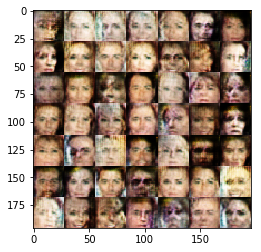


#############
Losses:
#############


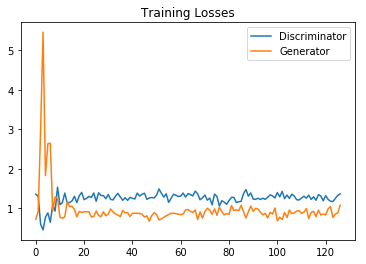

In [17]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

# NOTES

resources used:
* Deep Learning=> Ian Goodfellow, Yoshua Bengio, and Aaron Courville", Chapter 12: Generative Adversarial Networks, p690
* Generative Adversarial Nets => by Goodfellow et al, 2014 [paper on arxiv.org](https://arxiv.org/abs/1406.2661)
* GAN Hacks => [Github - soutmith](https://github.com/soumith/ganhacks#2-a-modified-loss-function)
* Implementing a Generative Adversarial Network (GAN/DCGAN) to Draw Human Faces => [article](https://towardsdatascience.com/implementing-a-generative-adversarial-network-gan-dcgan-to-draw-human-faces-8291616904a), [github](https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/DCGAN-face-creation.ipynb)
* DLND #Project_5 Slack channel => [this comment](https://nd101.slack.com/archives/C3QVCQHGW/p1508699907000007)

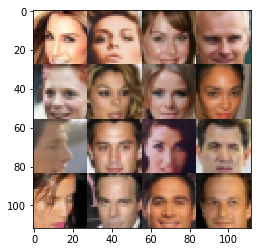

In [29]:
def show_img(show_n_images = 16, data='mnist'):
    if data == 'mnist':
        mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
        pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
    else:
        data = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
        pyplot.imshow(helper.images_square_grid(data, 'RGB'))
        
    
show_img(data='celeba')


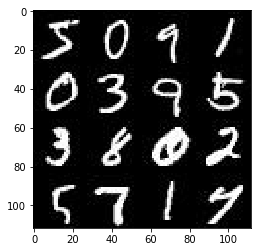

In [30]:
show_img(show_n_images = 16, data='mnist')